In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

pd.set_option("display.max_colwidth", None)

In [3]:
def viz_tree(tree_discr, continuous_attributes, tree_outputdir, suffix, saveFig=False):
    import os

    tree_discr.printDiscretizationTrees(round_v=3)

    if type(tree_discr.trees) is dict:
        dot = {}
        for attribute in continuous_attributes:
            dot[attribute] = tree_discr.trees[attribute].visualizeTreeDiGraph()
            if saveFig:
                dot[attribute].render(
                    os.path.join(tree_outputdir, f"tree_{attribute}_{suffix}.pdf")
                )
        dot_show = dot[attribute]
    else:
        dot_show = tree_discr.trees.visualizeTreeDiGraph()
        if saveFig:

            dot_show.render(os.path.join(tree_outputdir, f"tree_{suffix}.pdf"))


def printable_top_k(FP_fm, metric, COL_info, K=3, abbreviations={}, th_redundancy=0):
    from divexplorer_generalized.FP_Divergence import FP_Divergence

    fp_divergence_i = FP_Divergence(FP_fm, metric=metric)

    FP_sorted_i = (
        fp_divergence_i.getDivergence(th_redundancy=th_redundancy)
        .sort_values(
            [fp_divergence_i.metric, fp_divergence_i.t_value_col], ascending=False
        )
        .head(K)
    )

    from utils_printable import printable

    COLS = COL_info + [fp_divergence_i.metric, fp_divergence_i.t_value_col]

    FP_print_i = printable(FP_sorted_i[COLS], abbreviations=abbreviations)
    return FP_print_i

In [4]:
out = {}
out_support = {}

In [5]:
COL_info_detail = ["itemsets", "support", "tn", "fp", "fn", "tp"]

COL_info = ["itemsets", "support"]

# Parameters

In [6]:
K=3

metric = "d_fpr"
t_value_col = "t_value_fp"
min_sup_divergence=0.05

In [7]:
metrics = ["d_fpr", "d_fnr", "d_accuracy", "d_error"]

In [8]:
name_output_dir = "output_compas"

In [9]:
saveFig = False

# Dataset

In [10]:
abbreviations = {
    "age_cat": "age",
    "priors_count": "#prior",
    "Greater than 45": ">45",
    "25 - 45": "25-45",
    "African-American": "Afr-Am",
    "c_charge_degree": "charge",
    "Less than 25": "<25",
    "=>": ">",
    "=<": "<",
    "length_of_stay": "stay",
    "Caucasian": "Cauc",
}

dataset_name = "compas"
risk_class_type = True

from import_datasets import import_process_compas

dfI, class_map = import_process_compas(
    risk_class=risk_class_type, continuous_col=True
)
dfI.reset_index(drop=True, inplace=True)

dfI["predicted"] = dfI["predicted"].replace({"Medium-Low": 0, "High": 1})
true_class_name, pred_class_name = "class", "predicted"
class_and_pred_names = [true_class_name, pred_class_name]
attributes = list(dfI.columns.drop(class_and_pred_names))

dfI = dfI[attributes + class_and_pred_names]
dfI.head()

,c_charge_degree,race,sex,age,priors_count,length_of_stay,class,predicted
0,F,Other,Male,69,0,1.0,0,0
1,F,African-American,Male,34,0,10.0,1,0
2,F,African-American,Male,24,4,1.0,1,0
3,M,Other,Male,44,0,1.0,0,0
4,F,Caucasian,Male,41,14,6.0,1,0


# Tree divergence - error

In [11]:
show_fig = False
saveFig = False

In [12]:
import os


tree_outputdir = os.path.join(".", "output", "figures", "compas", "tree")
if saveFig:
    from pathlib import Path

    Path(tree_outputdir).mkdir(parents=True, exist_ok=True)

In [13]:
complete_info=False

if complete_info:
    COL_info = ["itemsets", "support", "tn", "fp", "fn", "tp"]
else:
    COL_info = ["itemsets", "support"]

## Tree divergence -fpr 0.025


In [14]:
cols_c = ["class", "predicted"]
continuous_attributes = ["priors_count", "length_of_stay", "age"]


type_criterion="weighted_sum_abs_reference_s"

type_experiment = "one_at_time"

min_sup_divergence = 0.025

In [15]:
min_support_trees = [0.005, 0.01, 0.02, 0.025, 0.035, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3]

In [16]:
display_res = False

In [17]:
all_results = {}

In [18]:
for min_support_tree in min_support_trees:

    if min_support_tree in all_results:
        out = all_results[min_support_tree]
    else:
        out = {}
        
    print(min_support_tree, end = " ")

    df_analyze = dfI.copy()

    from tree_discretization import TreeDiscretization

    tree_discr = TreeDiscretization()

    # ## Extract tree
    generalization_dict, discretizations = tree_discr.get_tree_discretization(
        df_analyze,
        type_splitting=type_experiment,
        min_support=min_support_tree,
        metric=metric,
        class_map=class_map,
        continuous_attributes=list(continuous_attributes),
        class_and_pred_names=cols_c,
        storeTree=True,
        type_criterion=type_criterion,
        # minimal_gain = 0.0015
    )
    
    considerOnlyContinuos = True
    if considerOnlyContinuos:
        for k in list(generalization_dict.keys()):
            if k not in continuous_attributes:
                generalization_dict.pop(k, None)
                
    for apply_generalization in [False, True]:
        
        if apply_generalization == True:
            type_gen = "generalized"
        else:
            type_gen = "base"
        
        if type_gen in out:
            continue
        #print(apply_generalization, type_gen)
        
        from utils_extract_divergence_generalized import (
            extract_divergence_generalized,
        )

        FP_fm = extract_divergence_generalized(
            df_analyze,
            discretizations,
            generalization_dict,
            continuous_attributes,
            min_sup_divergence=min_sup_divergence,
            apply_generalization=apply_generalization,
            true_class_name=true_class_name,
            predicted_class_name=pred_class_name,
            class_map=class_map,
            FPM_type="fpgrowth",
        )


        if display_res:
            display(printable_top_k(
                FP_fm, metric, COL_info_detail, K=K, abbreviations=abbreviations))

        out[type_gen] = printable_top_k(
            FP_fm, metric, COL_info, K=K, abbreviations=abbreviations
        )
    all_results[min_support_tree] = out

0.005 

/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")
/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")


0.01 

/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")
/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")


0.02 

/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")
/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")


0.025 

/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")
/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")


0.035 

/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")
/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")


0.05 

/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")
/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")


0.075 

/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")
/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")


0.1 

/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")
/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")


0.125 

/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")
/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")


0.15 

/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")
/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")


0.175 

/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")
/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")


0.2 

/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")
/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")


0.25 

/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")
/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")


0.3 

/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")
/Users/eliana/Projects/hierarchical-subgroup-exploration-private/utils_printable.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_print.columns = df_print.columns.str.replace("d_*", f"{div_name}_")


In [19]:

vs = []
for min_support_tree in all_results:
    out = all_results[min_support_tree]
    for type_gen in out:
        vs.append([min_support_tree, type_gen] + list(out[type_gen].iloc[0].values))
result = pd.DataFrame(vs, columns = ["min_sup", "type_gen"] + list(out[type_gen].columns))
display(result)

,min_sup,type_gen,itemsets,sup,Δ_fpr,t_fp
0,0.005,base,"age=21, race=Afr-Am",0.03,0.231,4.3
1,0.005,generalized,"age=[25-32], charge=F, #prior>=9, sex=Male",0.03,0.621,7.7
2,0.010,base,"age=21, race=Afr-Am",0.03,0.231,4.3
3,0.010,generalized,"age=[25-32], charge=F, #prior>=9, sex=Male",0.03,0.621,7.7
4,0.020,base,#prior=[14-18],0.03,0.384,4.8
5,0.020,generalized,"age=[25-32], charge=F, #prior>=9, sex=Male",0.03,0.621,7.7
6,0.025,base,"#prior>=14, race=Afr-Am",0.04,0.382,5.6
7,0.025,generalized,"age=[25-32], charge=F, #prior>=9, sex=Male",0.03,0.621,7.7
8,0.035,base,"#prior>=14, race=Afr-Am",0.04,0.382,5.6
9,0.035,generalized,"age=[25-32], charge=F, #prior>=9, sex=Male",0.03,0.621,7.7


### Plot 1

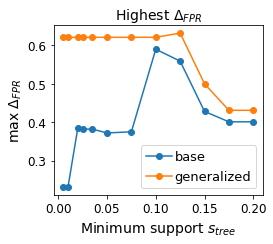

In [52]:
show_sup = [0.005, 0.01, 0.02, 0.025, 0.035, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]



from pathlib import Path
outfig_dir = "0_output_figures"
Path(outfig_dir).mkdir(parents=True, exist_ok=True)

import matplotlib.pyplot as plt



metric_name = "Δ_fpr"


vs = {}


fig, ax = plt.subplots(figsize = (4,3.5))

base = { min_support_tree: all_results[min_support_tree]["base"].iloc[0][metric_name] for min_support_tree in all_results if min_support_tree in show_sup}
gen =  { min_support_tree: all_results[min_support_tree]["generalized"].iloc[0][metric_name] for min_support_tree in all_results if min_support_tree in show_sup}

base = dict(sorted(base.items(), key=lambda item: item[0]))
gen = dict(sorted(gen.items(), key=lambda item: item[0]))
ax.set_title(r"Highest Δ$_{FPR}$")


ax.plot(list(base.keys()), list(base.values()), label = "base", marker = "o")
ax.plot(list(gen.keys()), list(gen.values()), label = "generalized", marker = "o")
ax.set_ylabel(r"max Δ$_{FPR}$")
ax.set_xlabel(r"Minimum support $s_{tree}$")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] ): #ax.get_xticklabels()
        item.set_fontsize(14)

for item in ax.get_xticklabels() + ax.get_yticklabels():
     item.set_fontsize(12)
        
plt.legend( fontsize = 13, handletextpad=0.2)



plt.tight_layout();
plt.savefig(f"{outfig_dir}/compas_sensitivity_s_{min_sup_divergence}.pdf");

### Plot 2

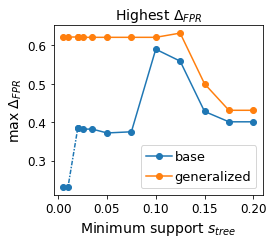

In [51]:
show_sup_dotted = [0.005, 0.01, 0.02 ]
show_sup = [0.02, 0.025, 0.035, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]



from pathlib import Path
outfig_dir = "0_output_figures"
Path(outfig_dir).mkdir(parents=True, exist_ok=True)

import matplotlib.pyplot as plt



metric_name = "Δ_fpr"


vs = {}


fig, ax = plt.subplots(figsize = (4,3.5))

base = { min_support_tree: all_results[min_support_tree]["base"].iloc[0][metric_name] for min_support_tree in all_results if min_support_tree in show_sup}
gen =  { min_support_tree: all_results[min_support_tree]["generalized"].iloc[0][metric_name] for min_support_tree in all_results if min_support_tree in show_sup}

base = dict(sorted(base.items(), key=lambda item: item[0]))
gen = dict(sorted(gen.items(), key=lambda item: item[0]))
ax.set_title(r"Highest Δ$_{FPR}$")
base_dotted = { min_support_tree: all_results[min_support_tree]["base"].iloc[0][metric_name] for min_support_tree in all_results if min_support_tree in show_sup_dotted}
gen_dotted =  { min_support_tree: all_results[min_support_tree]["generalized"].iloc[0][metric_name] for min_support_tree in all_results if min_support_tree in show_sup_dotted}

base_dotted = dict(sorted(base_dotted.items(), key=lambda item: item[0]))
gen_dotted = dict(sorted(gen_dotted.items(), key=lambda item: item[0]))

b, = ax.plot(list(base.keys()), list(base.values()), label = "base", marker = "o", c = "C0")
g, = ax.plot(list(gen.keys()), list(gen.values()), label = "generalized", marker = "o", c = "C1")
ax.plot(list(base_dotted.keys()), list(base_dotted.values()), label = "base", marker = "o", c = "C0", linestyle=(0, (3, 1, 1, 1)))
ax.plot(list(gen_dotted.keys()), list(gen_dotted.values()), label = "generalized", marker = "o", c = "C1", linestyle=(0, (3, 1, 1, 1)))
ax.set_ylabel(r"max Δ$_{FPR}$")
ax.set_xlabel(r"Minimum support $s_{tree}$")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] ): #ax.get_xticklabels()
        item.set_fontsize(14)

for item in ax.get_xticklabels() + ax.get_yticklabels():
     item.set_fontsize(12)
        
ax.legend([b, g], ['base', 'generalized'], fontsize = 13,  handletextpad=0.2)
#plt.legend( )


plt.tight_layout();
plt.savefig(f"{outfig_dir}/compas_sensitivity_s_{min_sup_divergence}.pdf");

In [48]:
outfig_dir

'0_output_figures'